# Numerical simulation of FAST applied to a 2d film (see paper text for details) 

In [1]:
%load_ext autoreload
%autoreload 2

In [35]:
import fast.s26_analysis.utils as utils 
from fast.utils.generate_scan_pattern import generate_scan_pattern as gcn

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib as mpl
import skimage
from tqdm.notebook import tqdm
import tifffile as tif
import joblib

In [36]:
ground = tif.imread('fused_full.tif')

# normalizing
ground = (ground - ground.min()) / (ground.max() -ground.min()) * 100

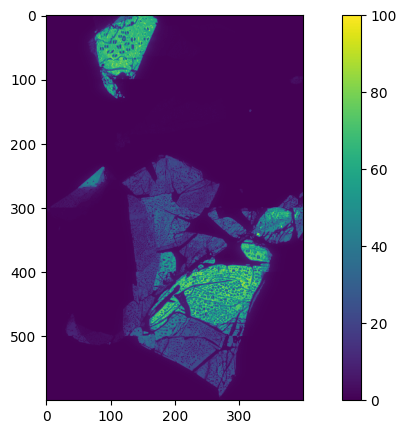

In [37]:
plt.figure(figsize=[10, 5])
plt.imshow(ground)
plt.colorbar()

### Simulating the FAST procedure only
Outer Steps:
1. Generate the initial random scan pattern.
2. Use the ground truth image to set the sample parameters.
3. Run the fast procedure until stopping.

Inner steps for 3:
1. Identify points to measure (just the random scan pattern for the first step)
3. Experiment only (not in the simulation): Calculate the optimal scan path.
4. Supply the corresponding data from the ground truth image
5. Perform a reconstruction from the data collected so far, and use this to compute the ERD for unmeasured points.
6. Identify a batch of 50 new measurement points based on the ERD.

**Note about the stopping condition**: While the authos in Ref. [1] propose a sophisticated stopping condition, we use naive visual guidance as the stopping criteria in the beamline experiment. For the simulation, we run the algorithm until we sample 20% of the points. 

[1] G. M. D. P. Godaliyadda, D. H. Ye, M. D. Uchic, M. A. Groeber, G. T. Buzzard and C. A. Bouman, "A Framework for Dynamic Image Sampling Based on Supervised Learning," in IEEE Transactions on Computational Imaging, vol. 4, no. 1, pp. 1-16, March 2018, doi: 10.1109/TCI.2017.2777482.

In [38]:
# Get a 1% measurement mask
init_pattern = gcn(*ground.T.shape, 0.01)

Initial ratio is 0.01


Text(0.5, 1.0, 'Initial scan pattern')

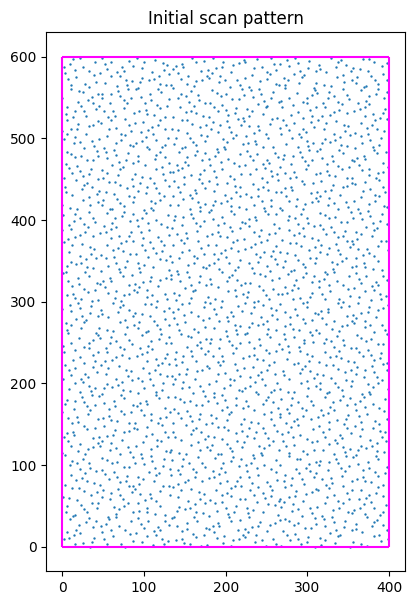

In [39]:
plt.figure(figsize=[7, 7])
plt.scatter(init_pattern[:,1], init_pattern[:,0], s=0.5)
plt.vlines([0, 400], ymin=0, ymax=600, color='magenta')
plt.hlines([0, 600], xmin=0, xmax=400, color='magenta')
plt.gca().set_aspect('equal')
plt.title('Initial scan pattern')

In [40]:
# Specifying the trained nn model to use
# We use the model generated for c=2.
erd_model_to_load = Path.cwd().parent / 'training/cameraman/c_2/erd_model_relu.pkl'

In [41]:
# Creating a simulated sample
# Setting the initial batch size to 50 (inner_batch_size=50)
# Supplying the nn model path
sample_fast = utils.create_experiment_sample(numx=ground.shape[1], numy=ground.shape[0],
                                        inner_batch_size=50,
                                        initial_idxs=init_pattern,
                                        erd_model_file_path=erd_model_to_load)

In [55]:
import fast.s26_analysis.utils as utils 
from fast.utils.generate_scan_pattern import generate_scan_pattern as gcn

In [59]:
# Actual simulation run. This can be fairly time consuming
recons_fast_all = []
ratios_all = []
tot_erds_all = []
count = 0
new_idxs = init_pattern

print('outer batch size = {}'.format(sample_fast.params_sample.outer_batch_size))
print('inner batch size = {}'.format(sample_fast.params_sample.inner_batch_size))

n_scan_points = int(0.2 * ground.size)
pbar = tqdm(total=n_scan_points, desc='Scanned points')
# Continue until we measure 20% of the points.
while sample_fast.mask.sum() < n_scan_points:
    # Supply the measurement values.
    sample_fast.measurement_interface.finalize_external_measurement(ground[new_idxs[:,0], new_idxs[:,1]])
    
    # Supply in measurement positions
    sample_fast.perform_measurements(new_idxs)
    
    # Use the measurement values to reconstruct the sample and calculate the ERDs
    sample_fast.reconstruct_and_compute_erd()
    
    # Compute new positions.
    new_idxs = sample_fast.find_new_measurement_idxs()[:50]
    
    ratio = sample_fast.ratio_measured
    ratios_all.append(ratio)
    tot_erds_all.append(sample_fast.ERD.sum())
    recons_fast_all.append(sample_fast.recon_image.copy())
    
    pbar.update(int(sample_fast.mask.sum() - pbar.n))

outer batch size = 1
inner batch size = 50


Scanned points:   0%|          | 0/48000 [00:00<?, ?it/s]

[0. 0. 0. ... 0. 0. 0.] 648.7448765550336
[0. 0. 0. ... 0. 0. 0.] 192.63933227346234
[0. 0. 0. ... 0. 0. 0.] 160.6111932665671
[0. 0. 0. ... 0. 0. 0.] 373.35827131891085
[0. 0. 0. ... 0. 0. 0.] 340.822204768795
[0. 0. 0. ... 0. 0. 0.] 173.65826891338938
[0. 0. 0. ... 0. 0. 0.] 573.0770541927918
[0. 0. 0. ... 0. 0. 0.] 375.24368179065505
[0. 0. 0. ... 0. 0. 0.] 266.3913016896815
[0. 0. 0. ... 0. 0. 0.] 527.0109115466475
[0. 0. 0. ... 0. 0. 0.] 817.5776350907734
[0. 0. 0. ... 0. 0. 0.] 743.9201845493099
[0. 0. 0. ... 0. 0. 0.] 374.93580206348065


KeyboardInterrupt: 

Text(0.5, 0, 'Scan coverage')

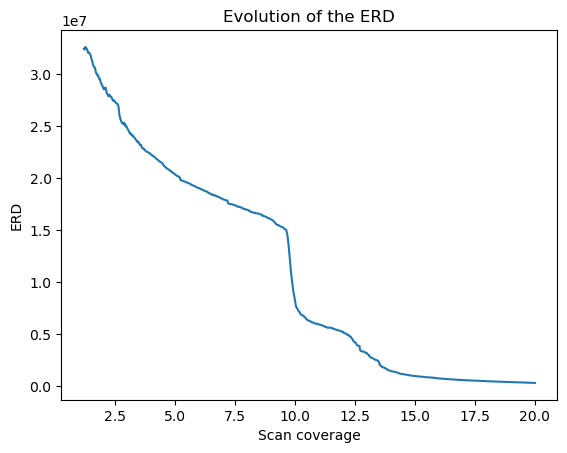

In [133]:
plt.plot(np.array(ratios_all)[10:] * 100, tot_erds_all[10:])
plt.title('Evolution of the ERD')
plt.ylabel('ERD')
plt.xlabel('Scan coverage')

We can see that the ERD stabilizes at around 15% coverage.

In [122]:
len(ratios_all)

913

In [ ]:
for ix in range(10, len(ratios_all), 100):
    plt.figure(figsize=[10, 5])
    plt.imshow(recons_fast_all[ix])
    plt.title(f'Scan coverage is {ratios_all[ix] * 100: 3.2f}%')
    plt.show()
    